In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

from tensorflow import keras
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

from sklearn.preprocessing import MinMaxScaler

Epoch 1/25
67/67 [==============================] - 7s 51ms/step - loss: 0.0139
Epoch 2/25
67/67 [==============================] - 3s 50ms/step - loss: 0.0029
Epoch 3/25
67/67 [==============================] - 3s 45ms/step - loss: 0.0030
Epoch 4/25
67/67 [==============================] - 3s 45ms/step - loss: 0.0034
Epoch 5/25
67/67 [==============================] - 3s 45ms/step - loss: 0.0023
Epoch 6/25
67/67 [==============================] - 3s 47ms/step - loss: 0.0021
Epoch 7/25
67/67 [==============================] - 3s 45ms/step - loss: 0.0024
Epoch 8/25
67/67 [==============================] - 3s 52ms/step - loss: 0.0021
Epoch 9/25
67/67 [==============================] - 3s 52ms/step - loss: 0.0022
Epoch 10/25
67/67 [==============================] - 3s 52ms/step - loss: 0.0018
Epoch 11/25
67/67 [==============================] - 3s 50ms/step - loss: 0.0018
Epoch 12/25
67/67 [==============================] - 3s 50ms/step - loss: 0.0019
Epoch 13/25
67/67 [==================

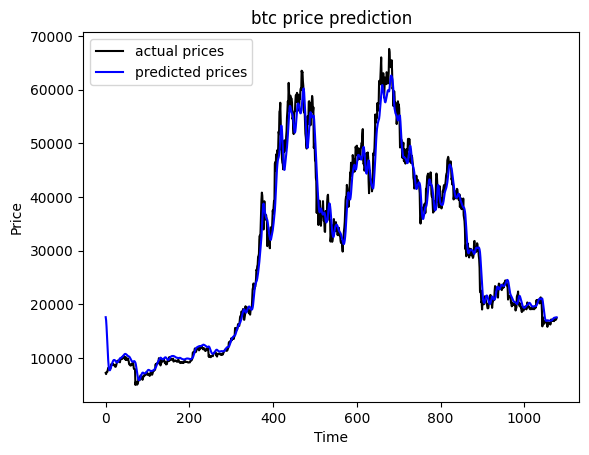

In [34]:
# coins and currency

coin = 'btc'
currency='USD'
 
 
# data time period

start = dt.datetime(2017,1,1)
end = dt.datetime.now()

data = web.DataReader(f'{coin}-{currency}','yahoo',start,end)


# scaling the Close values from data

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))


# number of price points t-1,t-2,... used to estimate price t

prediction_window = 60


# arrays containing the price points (y_window) for t and the windows (x_window) for t-1,t-2,...

x_window= []
y_window = []
    
for x in range(prediction_window, len(scaled_data)):
    x_window.append(scaled_data[x-prediction_window:x,0])
    y_window.append(scaled_data[x,0])
    
x_window = np.array(x_window)
y_window = np.array(y_window)

x_window = np.reshape(x_window, (x_window.shape[0],x_window.shape[1],1))


# LSTM model with Dropout to avoid overfitting

model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(x_window.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(x_window,y_window,epochs=25,batch_size=32)


# backtesting time frame for testing

test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()

test_data = web.DataReader(f'{coin}-{currency}','yahoo',test_start,test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'],test_data['Close']),axis=0)
model_inputs = total_dataset[len(total_dataset)-len(test_data)-prediction_window:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.fit_transform(model_inputs)

x_test = []

for x in range(prediction_window, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_window:x,0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

prediction_prices = model.predict(x_test)
prediction_prices = scaler.inverse_transform(prediction_prices)
# print(type(prediction_prices))
# np.savetxt("prediction_prices.csv", prediction_prices, delimiter=",")

plt.plot(actual_prices, color = 'black', label = 'actual prices')
plt.plot(prediction_prices, color = 'blue', label = 'predicted prices')
plt.title(f'{coin} price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc = 'upper left')
plt.show()

(1078,) (1078,)


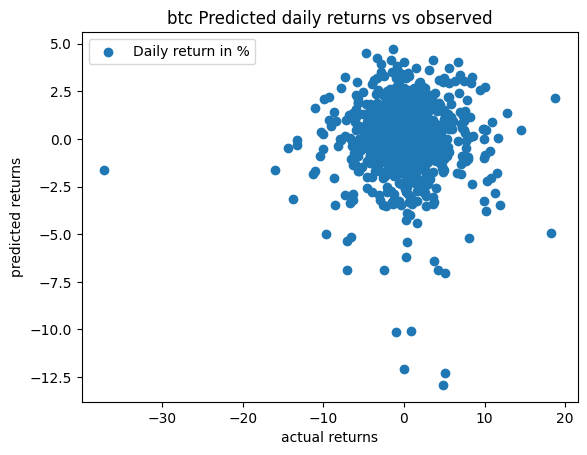

In [87]:
# correlation between predicted returns and actual returns

prediction_prices_temp = prediction_prices.reshape(prediction_prices.shape[0],)

pandas_predicted = pd.Series(prediction_prices_temp)
pandas_actual = pd.Series(actual_prices)

print(pandas_predicted.shape,pandas_actual.shape)

predicted_returns = (pandas_predicted/pandas_predicted.shift(1)-1)*100
actual_returns = (pandas_actual/pandas_actual.shift(1)-1)*100

return_data = pd.concat([actual_returns,predicted_returns],axis=1)
return_data.columns = ['actual_returns','predicted_returns']

plt.scatter(return_data['actual_returns'],return_data['predicted_returns'], label = 'Daily return in %')
plt.title(f'{coin} Predicted daily returns vs observed')
plt.xlabel('actual returns')
plt.ylabel('predicted returns')
plt.legend(loc = 'upper left')
plt.show()


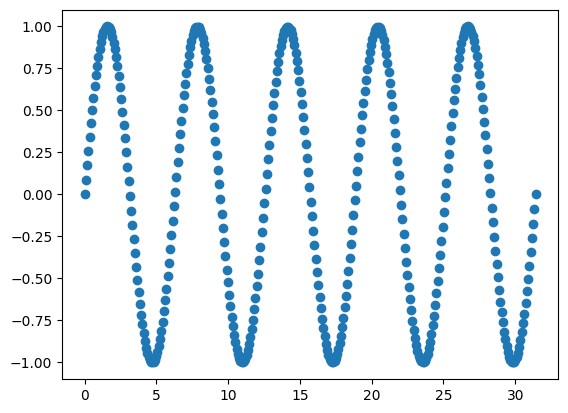

In [107]:
# testing the model with a deterministic data: sinus function
t = (data['Close'])
t = np.array(data['Close'])
x = np.linspace(0, 2*np.pi*5, 360)
y = np.sin(x)

plt.scatter(x, y)
plt.show()



In [115]:
# data -> sinus wave

data_sin = y


# scaling the Close values from data

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data_sin = scaler.fit_transform(data_sin.reshape(-1,1))


# number of price points t-1,t-2,... used to estimate price t

prediction_window = 30


# arrays containing the price points (y_window) for t and the windows (x_window) for t-1,t-2,...

x_window_sin= []
y_window_sin = []
    
for x in range(prediction_window, len(scaled_data_sin)):
    x_window_sin.append(scaled_data_sin[x-prediction_window:x,0])
    y_window_sin.append(scaled_data_sin[x,0])
    
x_window_sin = np.array(x_window_sin)
y_window_sin = np.array(y_window_sin)

x_window_sin = np.reshape(x_window_sin, (x_window_sin.shape[0],x_window_sin.shape[1],1))


# LSTM model with Dropout to avoid overfitting

model_sin = Sequential()
model_sin.add(LSTM(units=50,return_sequences=True,input_shape=(x_window_sin.shape[1],1)))
model_sin.add(Dropout(0.2))
model_sin.add(LSTM(units=50,return_sequences=True))
model_sin.add(Dropout(0.2))
model_sin.add(LSTM(units=50))
model_sin.add(Dropout(0.2))
model_sin.add(Dense(units=1))

model_sin.compile(optimizer='adam',loss='mean_squared_error')
model_sin.fit(x_window_sin,y_window_sin,epochs=25,batch_size=32)

Epoch 1/25
11/11 [==============================] - 4s 27ms/step - loss: 0.1686
Epoch 2/25
11/11 [==============================] - 0s 27ms/step - loss: 0.0771
Epoch 3/25
11/11 [==============================] - 0s 26ms/step - loss: 0.0300
Epoch 4/25
11/11 [==============================] - 0s 27ms/step - loss: 0.0100
Epoch 5/25
11/11 [==============================] - 0s 27ms/step - loss: 0.0065
Epoch 6/25
11/11 [==============================] - 0s 27ms/step - loss: 0.0063
Epoch 7/25
11/11 [==============================] - 0s 27ms/step - loss: 0.0048
Epoch 8/25
11/11 [==============================] - 0s 27ms/step - loss: 0.0041
Epoch 9/25
11/11 [==============================] - 0s 26ms/step - loss: 0.0045
Epoch 10/25
11/11 [==============================] - 0s 26ms/step - loss: 0.0053
Epoch 11/25
11/11 [==============================] - 0s 27ms/step - loss: 0.0049
Epoch 12/25
11/11 [==============================] - 0s 28ms/step - loss: 0.0054
Epoch 13/25
11/11 [==================

C:\Users\rgm\AppData\Local\Temp\ipykernel_14920\1738450991.py:13: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs_sin = total_dataset_sin[len(total_dataset_sin)-len(test_data_sin)-prediction_window:].values


180
Length of x_test_sin : 180
6/6 [==============================] - 1s 8ms/step
(180,)
(180, 1)


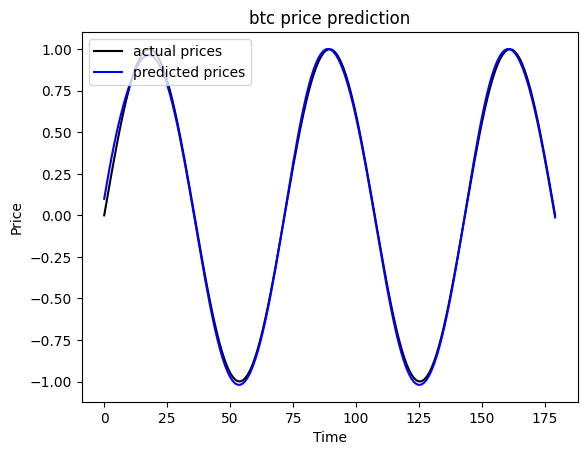

In [116]:
# backtesting time frame for testing

x2 = np.linspace(0, 2*np.pi*2.5, 180)
y2 = np.sin(x2)

test_data_sin = y2

pd_y = pd.Series(y)
pd_y2 = pd.Series(y2)

total_dataset_sin = pd.concat((pd_y,pd_y2),axis=0)

model_inputs_sin = total_dataset_sin[len(total_dataset_sin)-len(test_data_sin)-prediction_window:].values
model_inputs_sin = model_inputs_sin.reshape(-1,1)
model_inputs_sin = scaler.fit_transform(model_inputs_sin)


x_test_sin = []

for x in range(prediction_window, len(model_inputs_sin)):
    x_test_sin.append(model_inputs_sin[x-prediction_window:x,0])
    
print(len(x_test_sin))

print('Length of x_test_sin :',len(x_test_sin))
    
x_test_sin = np.array(x_test_sin)
x_test_sin = np.reshape(x_test_sin,(x_test_sin.shape[0],x_test_sin.shape[1],1))

prediction_prices_sin = model_sin.predict(x_test_sin)
prediction_prices_sin = scaler.inverse_transform(prediction_prices_sin)

print(test_data_sin.shape)
print(prediction_prices_sin.shape)

plt.plot(test_data_sin, color = 'black', label = 'actual prices')
plt.plot(prediction_prices_sin, color = 'blue', label = 'predicted prices')
plt.title(f'{coin} price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc = 'upper left')
plt.show()